In [ ]:
# 1. torch related libraries
import torch
import torch.nn as nn
import torchvision
#from torchvision.datasets import Food101
#import torchvision.transforms as T

import torchvision.models as models
from torchvision.models import ResNet18_Weights
#from torchvision.models import EfficientNet_B0_Weights

#Modular Pytorch
from Pytorch_Modules import custom_zipfile_download
from Pytorch_Modules import torch_prebuilt_data_folder_format
from Pytorch_Modules import plotting
from Pytorch_Modules import datasets
#from Pytorch_Modules import custom_model_builder
from Pytorch_Modules import metrics
from Pytorch_Modules import model_runtime

#os
import os

#model running time
from timeit import default_timer as timer

#current model info
from torchinfo import summary

/home/jagannath/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
'''#3. if using a prebuilt dataset from pytorch, then download using..
dataset=Food101(root="data",download=True) # only download if its not there, otherwise skip'''

'#3. if using a prebuilt dataset from pytorch, then download using..\ndataset=Food101(root="data",download=True) # only download if its not there, otherwise skip'

In [ ]:
#4. Fetching the Custom Dataset from the web. SKIP IF ALREADY DONE.
#custom dataset zip file download from web and extract. 
custom_zipfile_download.download_extract_kaggle(dataset="kmader/food41",
                                                data_path="data/food-101",
                                                zip_file_name="food41.zip")

In [ ]:
#5. then converting the dataset into structured folder (train and test) mentioned in meta folder.
#function for re-arranging the whole dataset inside one folder to a structure of 2 folder(train, test) 
# under the parent folder. (only use this if you are using a pytorch prebuilt dataset.)
torch_prebuilt_data_folder_format.folder_format(base_dir="data/food-101/images",
                                                train_file="data/food-101/meta/meta/train.txt",
                                                test_file="data/food-101/meta/meta/test.txt",
                                                train_dir="data/food-101/train",
                                                test_dir="data/food-101/test")

In [4]:
'''#Splitting the whole dataset into train and test folders if they are not 
#(some comes with that,but some does not.)
datasets.traintest_split(input_dir="data/indian-food/indian-food",
                          output_dir="data/indian-food",
                          train_split=0.2)'''

'#Splitting the whole dataset into train and test folders if they are not \n#(some comes with that,but some does not.)\ndatasets.traintest_split(input_dir="data/indian-food/indian-food",\n                          output_dir="data/indian-food",\n                          train_split=0.2)'

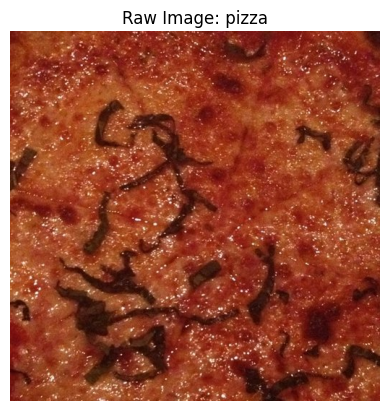


Image class: pizza
Image height: 512
Image width: 512
Image shape: (512, 512, 3)
Image data-type: uint8



In [3]:
#6. Plotting non transformed(raw) random images from the whole dataset.
plotting.plot_raw_random("data2/pizza_steak_sushi")

In [4]:
#7. Building the Custom CNN model

'''custom_model = custom_model_builder.CustomCNN(input_shape=3,hidden_units=32,output_shape=101)'''

#if using pretrained-model 
#model 1
ResNet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

'''# Freeze all base layers by setting requires_grad attribute to False
for param in ResNet.parameters():
    param.requires_grad = False'''

ResNet.fc = nn.Linear(512, 101)  # Replace the final layer for 101 classes
ResNet = ResNet.to(device)

In [5]:
'''#model 2
EfficientNet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Freeze all base layers by setting requires_grad attribute to False
for param in ResNet.parameters():
    param.requires_grad = False

EfficientNet.fc=nn.Linear(1408,101)
EfficientNet=EfficientNet.to(device)'''

'#model 2\nEfficientNet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)\n\n# Freeze all base layers by setting requires_grad attribute to False\nfor param in ResNet.parameters():\n    param.requires_grad = False\n\nEfficientNet.fc=nn.Linear(1408,101)\nEfficientNet=EfficientNet.to(device)'

In [5]:
#8. Setup pretrained weights (plenty of these available in torchvision.models)
resnet_weights = torchvision.models.ResNet18_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
resnet_transforms = resnet_weights.transforms() 
print(f"Automatically created transforms: {resnet_transforms}")

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
'''#8. Setup pretrained weights (plenty of these available in torchvision.models)
efficientnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
efficientnet_transforms = efficientnet_weights.transforms() 
print(f"Automatically created transforms: {efficientnet_transforms}")'''

'#8. Setup pretrained weights (plenty of these available in torchvision.models)\nefficientnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT\n\n# Get transforms from weights (these are the transforms that were used to obtain the weights)\nefficientnet_transforms = efficientnet_weights.transforms() \nprint(f"Automatically created transforms: {efficientnet_transforms}")'

In [7]:
#9. current model info
batch_size=64
summary(model=ResNet, 
        input_size=(batch_size, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 101]            --                   True
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [8]:
'''batch_size=64
summary(model=EfficientNet, 
        input_size=(batch_size, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])'''

'batch_size=64\nsummary(model=EfficientNet, \n        input_size=(batch_size, 3, 224, 224),\n        col_names=["input_size", "output_size", "num_params", "trainable"],\n        col_width=20,\n        row_settings=["var_names"])'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.0947855].


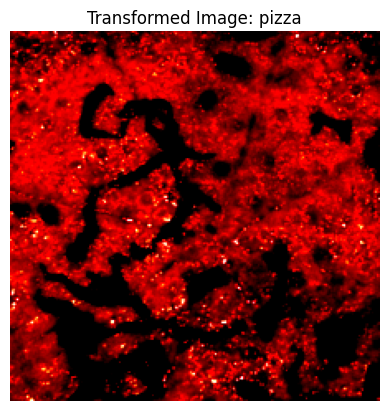


Image class: pizza
Image shape: torch.Size([3, 224, 224])
Image data type: torch.float32


In [9]:
# 10. Transforming and plotting the same raw images.
plotting.plot_transformed_random("data2/pizza_steak_sushi",transform=resnet_transforms)
#plotting.plot_transformed_random("data2/pizza_steak_sushi",transform=efficientnet_transforms)

In [10]:
#11 .Now creating the format for training and testing dataset in order to upload to the dataloader.

resnet_train_data,resnet_test_data=datasets.create_dataset(train_folder="data2/pizza_steak_sushi/train",
                                             test_folder="data2/pizza_steak_sushi/test",

                                             train_transform=resnet_transforms,
                                             test_transform=resnet_transforms,
                                             
                                             target_train_transform=None,
                                             target_test_transform=None)

'''efficientnet_train_data,efficientnet_test_data=datasets.create_dataset(train_folder="data2/pizza_steak_sushi/train",
                                             test_folder="data2/pizza_steak_sushi/test",

                                             train_transform=efficientnet_transforms,
                                             test_transform=efficientnet_transforms,
                                             
                                             target_train_transform=None,
                                             target_test_transform=None)'''

'efficientnet_train_data,efficientnet_test_data=datasets.create_dataset(train_folder="data2/pizza_steak_sushi/train",\n                                             test_folder="data2/pizza_steak_sushi/test",\n\n                                             train_transform=efficientnet_transforms,\n                                             test_transform=efficientnet_transforms,\n                                             \n                                             target_train_transform=None,\n                                             target_test_transform=None)'

In [11]:
#12. Preparing Dataloader
resnet_train_loader,resnet_test_loader=datasets.Dataloader(train_dataset=resnet_train_data,
                                             test_dataset=resnet_test_data,

                                             batch_size=64,
                                             num_workers=os.cpu_count(),
                                             
                                             train_shuffle=True,
                                             test_shuffle=False)

'''efficientnet_train_loader,efficientnet_test_loader=datasets.Dataloader(train_dataset=efficientnet_train_data,
                                             test_dataset=efficientnet_test_data,

                                             batch_size=64,
                                             num_workers=os.cpu_count(),
                                             
                                             train_shuffle=True,
                                             test_shuffle=False)'''

'efficientnet_train_loader,efficientnet_test_loader=datasets.Dataloader(train_dataset=efficientnet_train_data,\n                                             test_dataset=efficientnet_test_data,\n\n                                             batch_size=64,\n                                             num_workers=os.cpu_count(),\n                                             \n                                             train_shuffle=True,\n                                             test_shuffle=False)'

In [ ]:
#13. Untrained Prediction
torch.manual_seed(41)
for images, labels in resnet_train_loader:
  images, labels = images.to(device), labels.to(device)
  prediction = ResNet(images)
  break
prediction[0]

tensor([ 0.4191, -1.1615,  0.7068, -0.2566,  1.6257, -0.7264, -0.5519,  0.6724,
        -0.3594, -0.8743,  0.7533,  0.5306,  0.3612, -0.0387,  0.2823,  0.1778,
         0.3335,  0.0336,  0.2826, -0.3152,  0.3581, -1.0581,  1.0566, -0.4592,
        -1.5443,  0.0517,  0.4024, -0.6534,  0.1973,  0.3280,  0.2532,  0.2216,
        -0.9918, -0.8737, -0.5106,  0.0377, -0.1868, -0.9101, -0.3344,  1.2931,
         0.9246, -0.7935, -0.4268, -0.4956, -0.2331,  1.6296, -0.3293, -0.8190,
        -0.5711, -0.6095, -0.7947, -0.0629,  0.4790, -0.5932,  0.1538,  0.3158,
        -0.0699, -0.7644,  1.4029,  0.4508, -0.2420,  0.2688, -0.0091,  0.0085,
         0.4699, -0.1276,  0.1570, -0.2959, -1.7177,  0.2547,  0.3935,  0.3850,
         1.2868,  0.6249, -0.0293, -0.7363,  0.5734, -0.4031,  0.0137,  0.8141,
        -0.2708,  1.3190,  0.9682,  0.3531, -0.5313,  0.8252, -0.8093,  0.2591,
         0.6152, -0.7460, -1.6873,  1.3575, -0.3235,  1.0182, -0.9204,  0.4723,
        -0.7876,  0.6494, -0.0427,  0.03

In [ ]:
'''#13. Untrained Prediction
torch.manual_seed(40)
for images, labels in efficientnet_train_loader:
  images, labels = images.to(device), labels.to(device)
  prediction = EfficientNet(images)
  break
prediction[0]'''

'#14. Untrained Prediction\ntorch.manual_seed(40)\nfor images, labels in efficientnet_train_loader:\n  images, labels = images.to(device), labels.to(device)\n  prediction = EfficientNet(images)\n  break\nprediction[0]'

In [ ]:
#14. Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()

resnet_opt1 = torch.optim.Adam(ResNet.parameters(), lr=0.001)
resnet_opt2= torch.optim.SGD(ResNet.parameters(),lr=0.001,momentum=0.9)

'''efficientnet_opt1 = torch.optim.Adam(EfficientNet.parameters(), lr=0.001)
efficientnet_opt2= torch.optim.SGD(EfficientNet.parameters(),lr=0.001,momentum=0.9)'''


'efficientnet_opt1 = torch.optim.Adam(EfficientNet.parameters(), lr=0.001)\nefficientnet_opt2= torch.optim.SGD(EfficientNet.parameters(),lr=0.001,momentum=0.9)'

In [ ]:
#15. accuracy function
def accuracy(output, labels):
    '''# Accuracy Function'''
    _, pred = torch.max(output, dim=1)
    return torch.sum(pred == labels).item() / len(pred) * 100

In [ ]:
#16. Training the Model
start_time = timer()

experiment_configs = [
    {
        'model': ResNet,  # First model
        'optimizer': resnet_opt2,
        'epochs': 10,  # Number of epochs for model1
        'name': 'ResNet_Food_Classifying_Exp2'
    }
]

# Define the DataLoader for each model (train and test)
train_loaders = [resnet_train_loader]
test_loaders = [resnet_test_loader]

# Call the training function
metrics.train_plot_tensorboard_multiple_experiments(experiment_configs, train_loaders, test_loaders, loss_function)

end_time = timer()
model_runtime.run_time(start_time, end_time, device=device)

Training ResNet_Food_Classifying_Exp2...


 10%|█         | 1/10 [00:21<03:11, 21.24s/it]

Epoch 1/10
Training loss: 4.2225, Test loss: 3.8442
Training accuracy: 0.00%, Test accuracy: 9.33%
---------------------------------------------------------



 20%|██        | 2/10 [00:40<02:41, 20.13s/it]

Epoch 2/10
Training loss: 2.0962, Test loss: 1.7278
Training accuracy: 60.61%, Test accuracy: 54.67%
---------------------------------------------------------



 30%|███       | 3/10 [00:56<02:08, 18.36s/it]

Epoch 3/10
Training loss: 0.8871, Test loss: 0.9268
Training accuracy: 78.79%, Test accuracy: 66.67%
---------------------------------------------------------



 40%|████      | 4/10 [01:13<01:45, 17.55s/it]

Epoch 4/10
Training loss: 0.6005, Test loss: 0.7062
Training accuracy: 90.91%, Test accuracy: 74.67%
---------------------------------------------------------



 50%|█████     | 5/10 [01:29<01:25, 17.12s/it]

Epoch 5/10
Training loss: 0.4862, Test loss: 0.5739
Training accuracy: 81.82%, Test accuracy: 80.00%
---------------------------------------------------------



 60%|██████    | 6/10 [01:45<01:07, 16.84s/it]

Epoch 6/10
Training loss: 0.3108, Test loss: 0.4861
Training accuracy: 93.94%, Test accuracy: 85.33%
---------------------------------------------------------



 70%|███████   | 7/10 [02:02<00:49, 16.66s/it]

Epoch 7/10
Training loss: 0.2237, Test loss: 0.4312
Training accuracy: 100.00%, Test accuracy: 86.67%
---------------------------------------------------------



 80%|████████  | 8/10 [02:18<00:33, 16.55s/it]

Epoch 8/10
Training loss: 0.1902, Test loss: 0.3971
Training accuracy: 100.00%, Test accuracy: 89.33%
---------------------------------------------------------



 90%|█████████ | 9/10 [02:35<00:16, 16.63s/it]

Epoch 9/10
Training loss: 0.1611, Test loss: 0.3696
Training accuracy: 100.00%, Test accuracy: 90.67%
---------------------------------------------------------



100%|██████████| 10/10 [02:51<00:00, 17.16s/it]

Epoch 10/10
Training loss: 0.0888, Test loss: 0.3456
Training accuracy: 100.00%, Test accuracy: 90.67%
---------------------------------------------------------

Average Training loss for ResNet_Food_Classifying_Exp2: 0.9267
Average Test loss for ResNet_Food_Classifying_Exp2: 0.9809
Average Training accuracy for ResNet_Food_Classifying_Exp2: 80.61%
Average Test accuracy for ResNet_Food_Classifying_Exp2: 72.80%
The model took 171.601 seconds on device: cpu



171.60104346300068

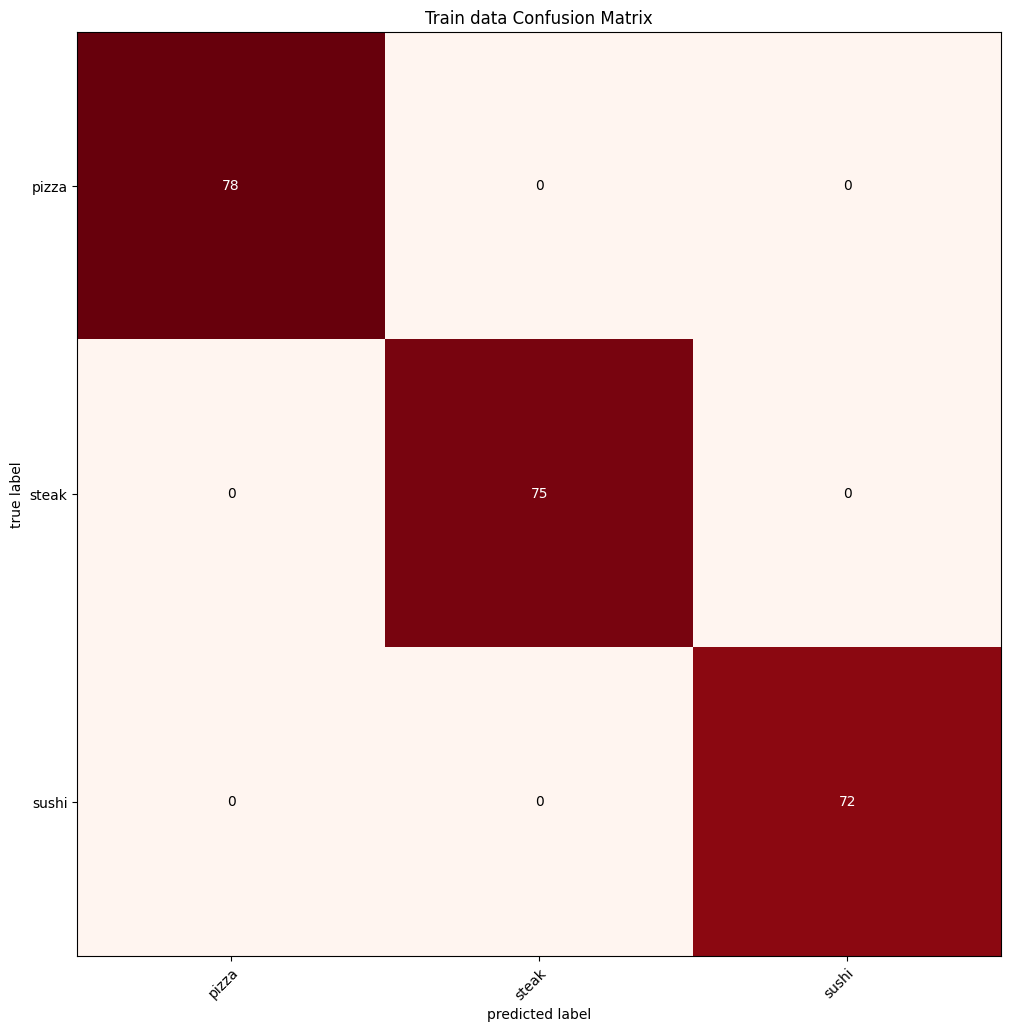

In [ ]:
#17. confusion matrix for both train and test
metrics.conf_matrix_for_train(model=ResNet,
                              image_path="data2/pizza_steak_sushi/train",
                              train_loader=resnet_train_loader)


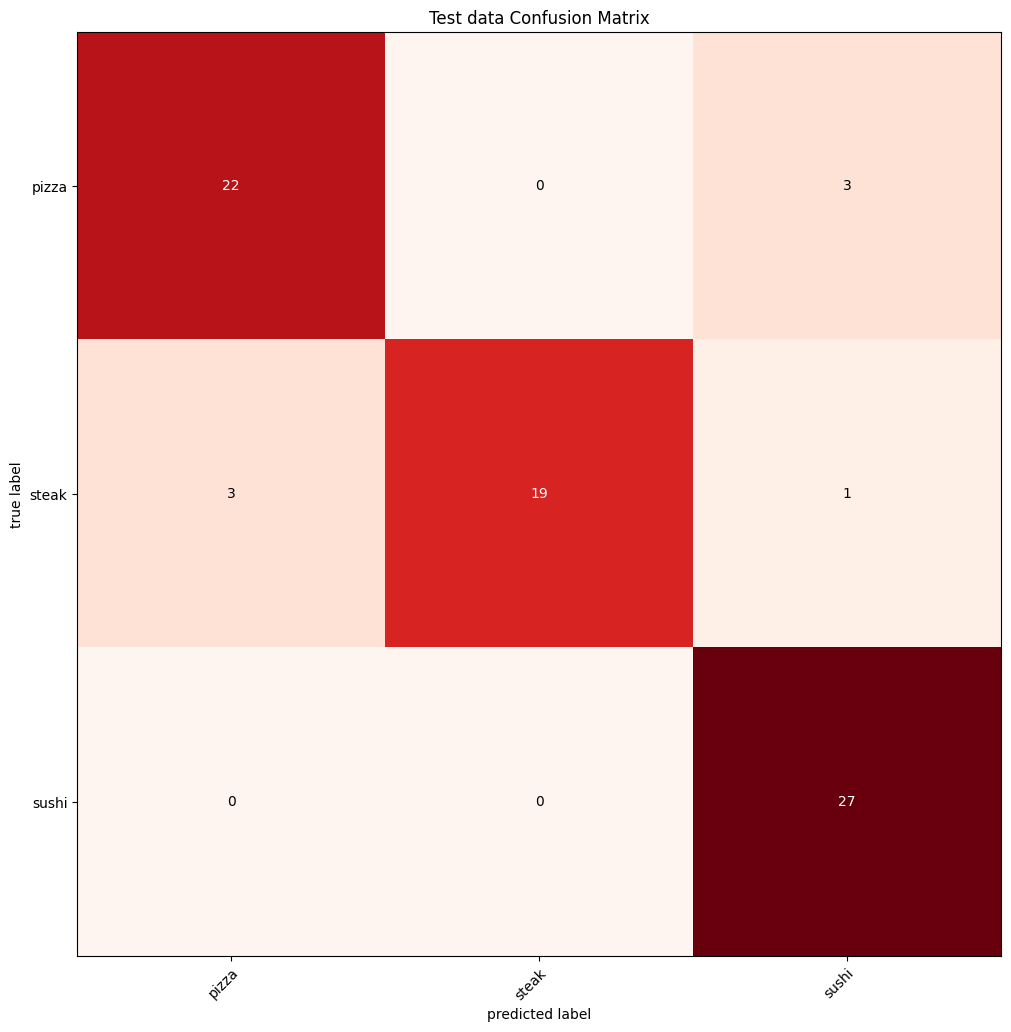

In [17]:
metrics.conf_matrix_for_test(model=ResNet,
                             image_path="data2/pizza_steak_sushi/test",
                             test_loader=resnet_test_loader)

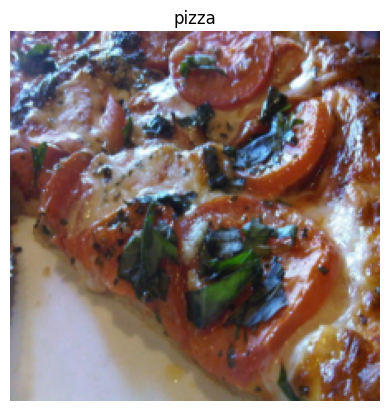


Model Prediction on Train set:  pizza


In [ ]:
#18. Train and Test images prediction
metrics.train_prediction(class_names_parent_path="data2/pizza_steak_sushi/train",model=ResNet,
                        image_path="data2/pizza_steak_sushi/train",
                        )

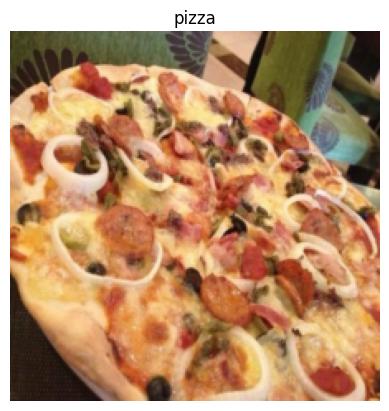


Model Prediction on Testset:  pizza


In [37]:
metrics.test_prediction(class_names_parent_path="data2/pizza_steak_sushi/test",model=ResNet,
                        image_path="data2/pizza_steak_sushi/test",
                        )

In [ ]:
#19. Saving and Loading Model
torch.save(ResNet.state_dict(), "Food_Classifier.pth")

load_model = ResNet
load_model.load_state_dict(torch.load("Food_Classifier.pth"))

/tmp/ipykernel_180406/728718268.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load("Food_Classifier.pth"))


<All keys matched successfully>

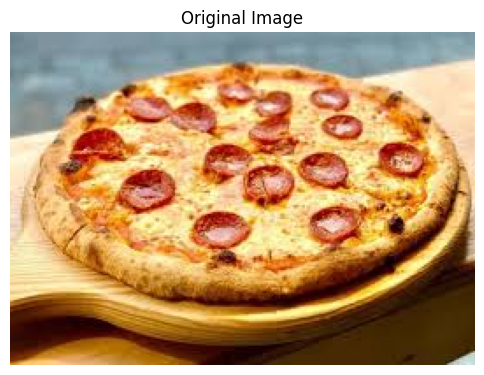


----------------------------------



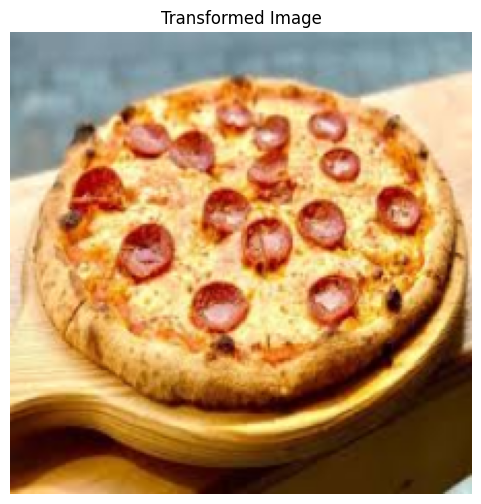

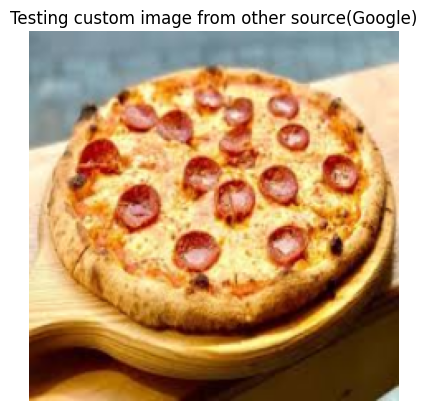


Model Prediction on custom image:  pizza


In [ ]:
#20. Testing the custom image
metrics.custom_image_plot(class_names_parent_path="data2/pizza_steak_sushi/test",
                          image_path="data/food-101/pizza.jpg",
                          device=device,
                          model=ResNet)